<a href="https://colab.research.google.com/github/orimejia/Proyecto-AI/blob/main/04_Modelos_sin_SMOTE_ENTREGAFINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **04 - Modelos sin SMOTE**


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel, mutual_info_classif, f_classif, SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

In [2]:
url = 'https://raw.githubusercontent.com/HernanAC/TaiwaneseBankruptcyPrediction/main/processed_data.csv'
data = pd.read_csv(url)

In [3]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,mean_absolute_error, accuracy_score, mean_squared_error, precision_score, f1_score,recall_score
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import itertools
from sklearn.svm import SVC
from sklearn.metrics import recall_score
import re

In [4]:
data.columns = data.columns.str.lstrip()
data.columns = [re.sub(r'(?<!^)(?=[A-Z])', '_', name).lower() for name in data.columns]

In [5]:
X = data.drop('bankrupt?', axis=1).values
Y = data['bankrupt?'].values
print (X.shape , Y.shape)

(6819, 111) (6819,)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,stratify=Y,test_size=0.30)

In [7]:
def calcularMatrizCF(matrix,titulo):
    a = (matrix[0,0] +  matrix[0,1])
    b = (matrix[1,0] +  matrix[1,1])
    matrix[0,0] =  matrix[0,0] / a
    matrix[0,1] =  matrix[0,1] / a
    matrix[1,0] =  matrix[1,0] / b
    matrix[1,1] =  matrix[1,1] / b 
    sns.heatmap(matrix,annot=True)
    plt.xlabel('Label Pred')
    plt.ylabel('Label True')
    plt.title(titulo)
    print(matrix)

In [8]:
def gradient_boosting_tree(X,y,num_trees): 
    skf = StratifiedKFold(n_splits=4)
    resultados = pd.DataFrame()
    conf_matrix_list_of_arrays = np.zeros(2)
    idx = 0  
    for trees in num_trees:
        EficienciaTrain = []
        EficienciaVal = []
        accuracy = []
        Macc = []
        Mpre = []
        Mrec = []
        Mf1 = []
        print(f"Training with {trees} trees...")
        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model = GradientBoostingClassifier(n_estimators=trees)
            model.fit(X_train,y_train)
            y_pred = model.predict(X_test)
            y_pred_train = model.predict(X_train)
            conf_matrix = confusion_matrix(y_test,y_pred)
            conf_matrix_list_of_arrays = conf_matrix_list_of_arrays + conf_matrix
            EficienciaTrain.append(np.mean(y_pred_train.ravel() == y_train.ravel()))
            EficienciaVal.append(np.mean(y_pred.ravel() == y_test.ravel()))
            accuracy.append(model.score(X_test, y_test))
            Macc.append(accuracy_score(y_test, y_pred))
            Mpre.append(precision_score(y_test, y_pred))
            Mrec.append(recall_score(y_test, y_pred))
            Mf1.append(f1_score(y_test, y_pred,average="weighted"))
        resultados.loc[idx,'número de arboles'] = trees
        resultados.loc[idx,'eficiencia de entrenamiento'] = np.mean(EficienciaTrain)
        resultados.loc[idx,'desviacion estandar entrenamiento'] = np.std(EficienciaTrain)
        resultados.loc[idx,'eficiencia de prueba'] = np.mean(EficienciaVal)
        resultados.loc[idx,'Intervalo de confianza (prueba)'] = np.std(EficienciaVal)
        resultados.loc[idx,'accuracy real'] = np.mean(Macc)
        resultados.loc[idx,'precision_score'] = np.mean(Mpre)
        resultados.loc[idx,'recall_score'] = np.mean(Mrec)
        resultados.loc[idx,'f1_score'] = np.mean(Mf1)
        idx= idx +1
    return (resultados, conf_matrix_list_of_arrays)

In [9]:
resultados_gbt, matrix_gbt = gradient_boosting_tree(X_train,y_train,[20,50,100,200,300])

Training with 20 trees...
Training with 50 trees...
Training with 100 trees...
Training with 200 trees...
Training with 300 trees...


In [10]:
resultados_gbt

,número de arboles,eficiencia de entrenamiento,desviacion estandar entrenamiento,eficiencia de prueba,Intervalo de confianza (prueba),accuracy real,precision_score,recall_score,f1_score
0,20.0,0.982052,0.001069,0.968573,0.001825,0.968573,0.558166,0.174764,0.960618
1,50.0,0.989036,0.000799,0.970459,0.002166,0.970459,0.587662,0.298920,0.965792
2,100.0,0.995251,0.001134,0.969412,0.002809,0.969412,0.552919,0.292341,0.964837
3,200.0,0.999441,0.000342,0.970040,0.001715,0.970040,0.567913,0.304993,0.965618
4,300.0,1.000000,0.000000,0.970250,0.001910,0.970250,0.565711,0.331309,0.966439


[[0.9927257  0.0072743 ]
 [0.71948052 0.28051948]]


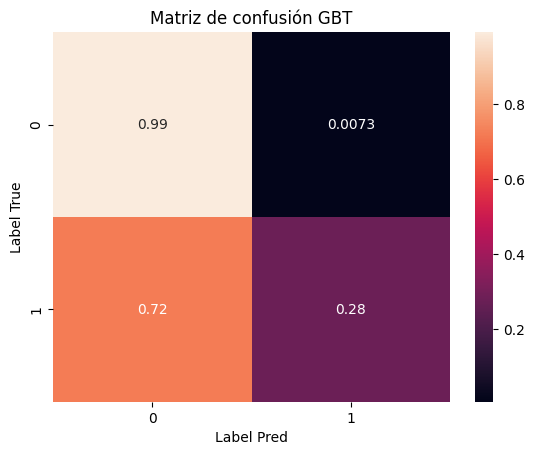

In [11]:
calcularMatrizCF(matrix_gbt, "Matriz de confusión GBT")

In [12]:
def support_vector_machine(x, y, kernels, gammas,params_reg):
    idx = 0
    kf = StratifiedKFold(n_splits=4)
    kernels_gammas_regs = list(itertools.product(kernels, gammas, params_reg))
    resultados = pd.DataFrame()
    conf_matrix_list_of_arrays = np.zeros(2)
    for params in kernels_gammas_regs:
        kernel, gamma, param_reg = params
        errores_train = []
        errores_test = []
        EficienciaVal = []
        pct_support_vectors = []
        Macc = []
        Mpre = []
        Mrec = []
        Mf1 = []
        print(f"Running with Kernel: {kernel}, Gamma: {gamma}, C: {param_reg} parameters...")
        for train_index, test_index in kf.split(x,y):
            X_train, X_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]  
            svm = SVC(kernel=kernel, gamma=gamma, C= param_reg)
            svm.fit(X=X_train, y=y_train)
            y_train_pred = svm.predict(X=X_train)
            y_test_pred = svm.predict(X=X_test)
            conf_matrix = confusion_matrix(y_test, svm.predict(X_test))
            conf_matrix_list_of_arrays = conf_matrix_list_of_arrays + conf_matrix
            errores_train.append(accuracy_score(y_true = y_train, y_pred = y_train_pred))
            errores_test.append(accuracy_score(y_true = y_test, y_pred = y_test_pred))
            n_train = X_train.shape[0]
            pct_vs = ( svm.support_vectors_.shape[0] /n_train)
            pct_support_vectors.append(pct_vs)
            Macc.append(accuracy_score(y_test, y_test_pred))
            Mpre.append(precision_score(y_test, y_test_pred))
            Mrec.append(recall_score(y_test, y_test_pred))
            Mf1.append(f1_score(y_test, y_test_pred,average="weighted",labels=np.unique(y_test_pred)))
            EficienciaVal.append(np.mean(y_test_pred.ravel() == y_test.ravel()))
        resultados.loc[idx,'kernel'] = kernel
        resultados.loc[idx,'gamma'] = gamma
        resultados.loc[idx,'param_reg'] = param_reg
        resultados.loc[idx,'error de entrenamiento'] = np.mean(errores_train)
        resultados.loc[idx,'error de prueba'] = np.mean(errores_test)
        resultados.loc[idx,'% de vectores de soporte'] = np.mean(pct_support_vectors)*100
        resultados.loc[idx,'accuracy real'] = np.mean(Macc)
        resultados.loc[idx,'Intervalo de confianza (prueba)'] = np.std(EficienciaVal)
        resultados.loc[idx,'precision_score'] = np.mean(Mpre)
        resultados.loc[idx,'recall_score'] = np.mean(Mrec)
        resultados.loc[idx,'f1_score'] = np.mean(Mf1)
        idx+=1
    return (resultados, conf_matrix_list_of_arrays)

In [13]:
resultados_svm, matrix_svm  = support_vector_machine(x = X,y=Y,
                                 kernels=['rbf'],
                                 gammas = [0.01],
                                 params_reg = [0.01]
                                )
resultados_svm

Running with Kernel: rbf, Gamma: 0.01, C: 0.01 parameters...


,kernel,gamma,param_reg,error de entrenamiento,error de prueba,% de vectores de soporte,accuracy real,Intervalo de confianza (prueba),precision_score,recall_score,f1_score
0,rbf,0.01,0.01,0.967737,0.967737,54.333484,0.967737,0.000008,0.0,0.0,0.983604
